# Klassifizierung von deutschsprachigen News-Artikel

Text-Klassifizierung ist eine Standard-Anwendung von ML. Hier zeige ich beispielhaft solch eine Klassifizierung anhand von Nachrichten-Meldung in deutscher Sprache.

Als Datenquelle kommt der "10k German News Articles Dataset (10kGNAD)" zum Einsatz. Entnommen wurde er von Kaggle: https://www.kaggle.com/tblock/10kgnad

Die vorgefertigte Aufteilung in Trainings- und Testdaten wurde rückgängig gemacht und selbst neu angefertigt.

Für die Auswertung kam Tensorboard zum Einsatz. Mit diesem Tool kann der Verlauf des Lernprozesses sehr schön visualisiert werden. Dafür muss Tensorboard installiert sein (pip install Tensorboard)

## Framework imports

In [1]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.regularizers import l2
from keras.callbacks import TensorBoard

Using TensorFlow backend.
/Users/axelschweiss/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/axelschweiss/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/axelschweiss/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/axelschweiss/anaconda3/lib/p

## Data load
Daten liegen in test- und train.csv Dateien vor. Ich will aber meinen eigenen Split vornehmen.
Deswegen werden beide Datensätze zu einem vereint.

In [2]:
filename = 'test.csv'
df_test = pd.read_csv(filename, header=None)
print(df_test.shape)
df_test.head()

(1028, 2)


,0,1
0,Wirtschaft,Die Gewerkschaft GPA-djp lanciert den All-in-R...
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


In [3]:
filename = 'train.csv'
df_train = pd.read_csv(filename, header=None)
print(df_train.shape)
#print(df['label'].value_counts())
df_train.head()

(9245, 2)


,0,1
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: Einigung, dass wir Menge auf Niveau von..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [4]:
df = pd.concat([df_train, df_test])

In [5]:
print(df.shape)

(10273, 2)


## Headers erstellen, Spalte 'target' erstellen
Für den weiteren Verlauf müssen die Labels als Zahlen gemapt werden.

In [6]:
headers = ['label', 'text']
df.columns = headers
df.head()

,label,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: Einigung, dass wir Menge auf Niveau von..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [7]:
df.label.unique()

array(['Sport', 'Kultur', 'Web', 'Wirtschaft', 'Inland', 'Etat',
       'International', 'Panorama', 'Wissenschaft'], dtype=object)

In [8]:
codes = {'Sport': 0, 'Kultur': 1, 'Web': 2, 'Wirtschaft': 3, 'Inland': 4, 'Etat': 5, 'International': 6, 'Panorama': 7, 'Wissenschaft': 8}
df['target'] = df['label'].map(codes)

In [9]:
df.head()

,label,text,target
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,0
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",1
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,2
3,Wirtschaft,"Putin: Einigung, dass wir Menge auf Niveau von...",3
4,Inland,Estland sieht den künftigen österreichischen P...,4


## Verkürzte Version der Texte
Damit die Texte einheitlich lang und vor allem nicht ZU LANG sind, wird eine auf 200 Zeichen begrenzte Version der Texte in der Spalte "text_shortened" erstellt.

In [10]:
df['text_shortened'] = df['text'].map(lambda x : x[:200])
df.head()

,label,text,target,text_shortened
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,0,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",1,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,2,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: Einigung, dass wir Menge auf Niveau von...",3,"Putin: Einigung, dass wir Menge auf Niveau von..."
4,Inland,Estland sieht den künftigen österreichischen P...,4,Estland sieht den künftigen österreichischen P...


## Datensatz in Trainings- und Testdaten aufteilen
Hier mal ohne Scikit-Learn :-)

In [11]:
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(8218, 4) (1742, 4)


## Daten für Keras vorbereiten
X- und Y-Aufteilung


In [12]:
print(df_train['target'].value_counts())
y_train = df_train['target'].values
y_test = df_test['target'].values

X_train_raw = df_train['text_shortened'].tolist()
X_test_raw = df_test['text_shortened'].tolist()

2    1340
7    1332
6    1202
3    1117
0     961
4     823
5     549
8     458
1     436
Name: target, dtype: int64


## Tokenizing

In [13]:
tok = Tokenizer()
tok.fit_on_texts(X_train_raw)

seq_train = tok.texts_to_sequences(X_train_raw) 
seq_test = tok.texts_to_sequences(X_test_raw) 
my_dict = tok.index_word
print(seq_train[:2])
print('Anzahl Wörter in dict', len(my_dict))

[[3, 501, 150, 18, 24, 6902, 76, 3, 6903, 83, 3450, 6, 2, 6904, 3054, 3055, 3056, 95, 5, 6903, 9414, 6905, 114, 37, 3], [16, 15150, 301, 1780, 322, 11, 15151, 76, 3, 348, 5506, 1, 15152, 1100, 116, 5, 437, 2462, 116, 6906, 6907, 2463, 20, 31, 1101, 3, 348, 5506]]
Anzahl Wörter in dict 38686


## Ersten 20 Wörter zum Anlernen verwenden

In [14]:
pad_train = pad_sequences(seq_train, maxlen=20, padding='post', truncating='post')
pad_test = pad_sequences(seq_test, maxlen=20, padding='post', truncating='post')
print(pad_train.shape)
pad_test[:2]

(8218, 20)


array([[ 4988,   160,    10,  7358,   377,   614,    34,    27,  3771,
            6,  7523, 36947,     2,     3,  2458,    19,  7358,  1919,
          204, 18446],
       [  507,  9060,   869,  4056,     2,   822,    11,  4921,  8283,
            4,  2243,     1,   869,     5, 13687,    46,  1487,    76,
          830, 12447]], dtype=int32)

## Keras-Modell erstellen
Mit einem LSTM-Layer

In [15]:
### Modell aufsetzen
anz_woerter = 44725
anz_dim = 30

model = keras.models.Sequential()
model.add(keras.layers.Embedding(anz_woerter+1, anz_dim, input_length=20))
model.add(keras.layers.LSTM(64, dropout=0.4, kernel_regularizer=l2(0.005)))
model.add(keras.layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 30)            1341780   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 1,366,685
Trainable params: 1,366,685
Non-trainable params: 0
_________________________________________________________________


## Tensorboard aktivieren

In [16]:
tensor_board_log = r'tensorboard_log'
callback_tb = [ TensorBoard(log_dir=tensor_board_log, histogram_freq=1) ]

## Modell trainieren

In [17]:
history = model.fit(pad_train, y_train, epochs=10, validation_data=(pad_test, y_test),
                      callbacks=callback_tb )

Instructions for updating:
Use tf.cast instead.
Train on 8218 samples, validate on 1742 samples
Epoch 1/10
8218/8218 [==============================] - 12s 1ms/step - loss: 2.1160 - acc: 0.1791 - val_loss: 1.9045 - val_acc: 0.2595
Epoch 2/10
8218/8218 [==============================] - 11s 1ms/step - loss: 1.6977 - acc: 0.3212 - val_loss: 1.7721 - val_acc: 0.3330
Epoch 3/10
8218/8218 [==============================] - 12s 1ms/step - loss: 1.3513 - acc: 0.4634 - val_loss: 1.7008 - val_acc: 0.3794
Epoch 4/10
8218/8218 [==============================] - 11s 1ms/step - loss: 1.0194 - acc: 0.6021 - val_loss: 1.7285 - val_acc: 0.4392
Epoch 5/10
8218/8218 [==============================] - 11s 1ms/step - loss: 0.7869 - acc: 0.7072 - val_loss: 1.7668 - val_acc: 0.4529
Epoch 6/10
8218/8218 [==============================] - 11s 1ms/step - loss: 0.6310 - acc: 0.7699 - val_loss: 1.7905 - val_acc: 0.4891
Epoch 7/10
8218/8218 [==============================] - 11s 1ms/step - loss: 0.5114 - acc: 0.8

## Tensorboard im Browser öffnen
http://localhost:6006

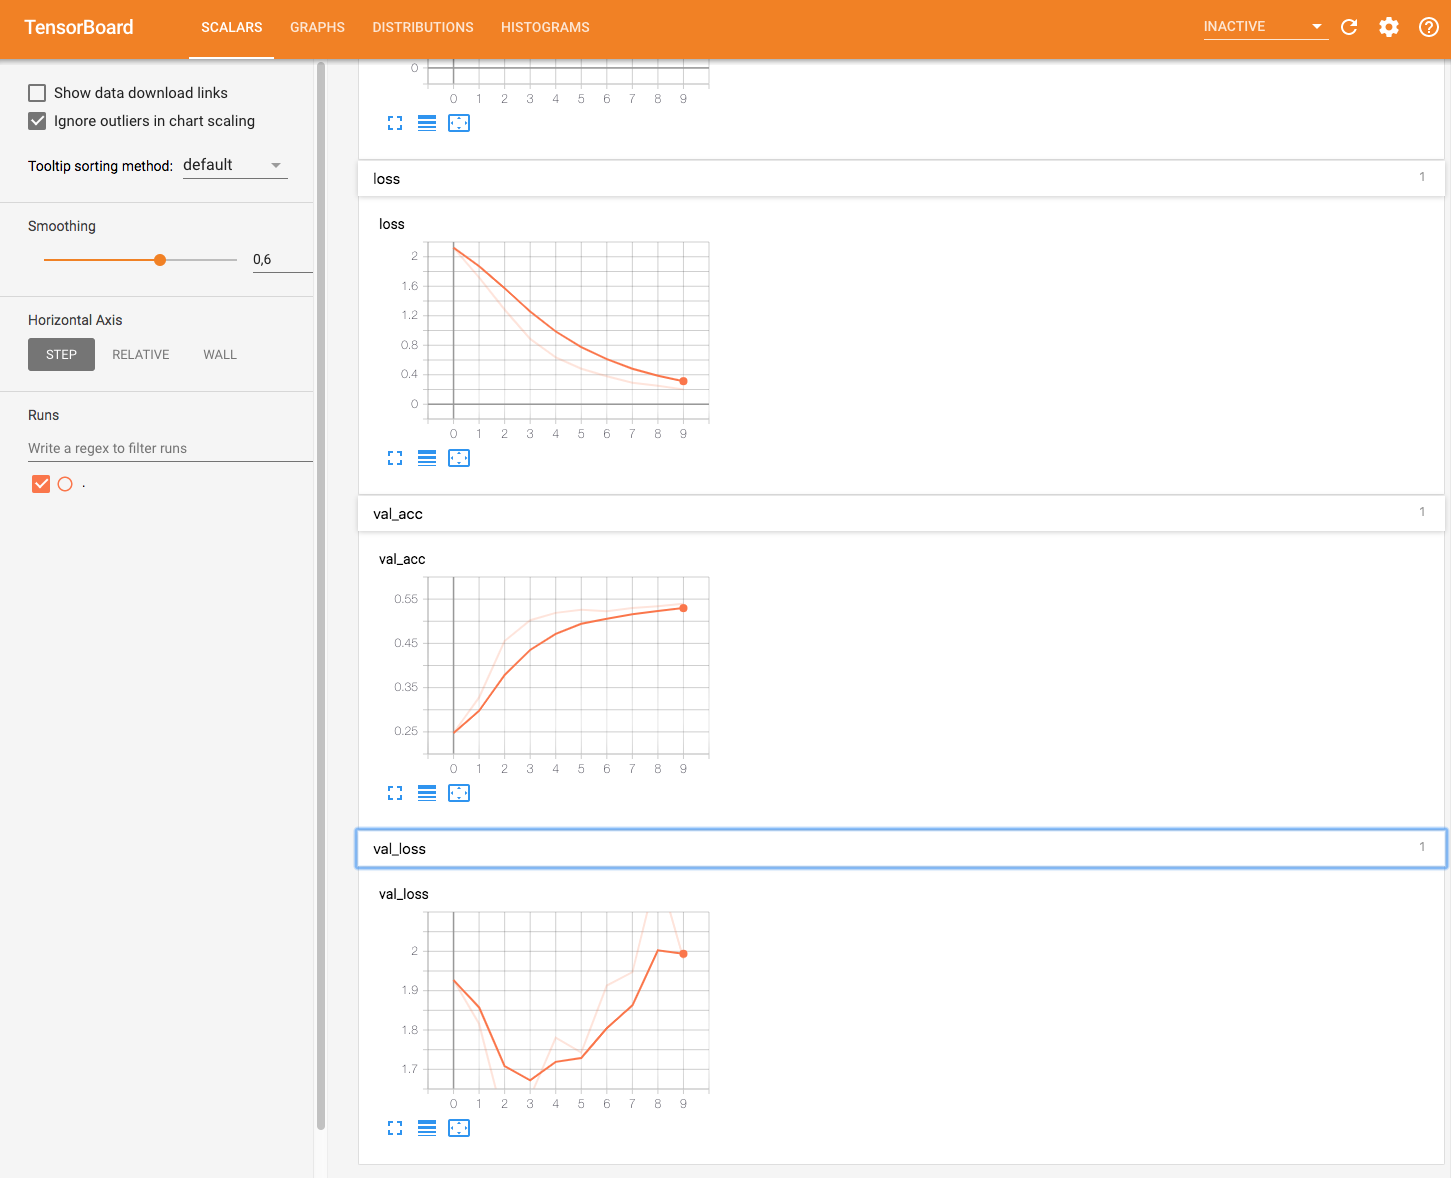